# Quora Questions Classification Based on Word Vectors
## using Spacy with vectors only statistical model en_vectors_web_lg

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'logistic_spacy_vectors')

In [3]:
quora = pd.read_csv('../data/.input/train.csv')

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [5]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target * 2.0 - 1.0
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target * 2.0 - 1.0

In [8]:
%%time

import spacy
nlp = spacy.load('en_vectors_web_lg')

Wall time: 28.8 s


In [12]:
def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

def to_vw_format(document, label=None):
    vector = vectorize_text(document)
    values = []
    for index, value in enumerate(vector):
        values.append('f{}:{}'.format(index, value))
    return str(label or '') + ' |n ' + ' '.join(values) + '\n'

to_vw_format(quora_train_data.iloc[0], quora_train_labels[0])[:70]

'-1.0 |n f0:-0.011226640082895756 f1:0.0914510041475296 f2:-0.168460875'

In [13]:
!!mkdir $WORKING_DIR
trainDataPath = os.path.join(WORKING_DIR, 'train.vw')
testDataPath = os.path.join(WORKING_DIR, 'test.vw')
modelPath = os.path.join(WORKING_DIR, 'model.vw')
predictionsPath = os.path.join(WORKING_DIR, 'test_predictions.txt')
cachePath = os.path.join(WORKING_DIR, 'cache')

In [14]:
%%time

with open(trainDataPath, 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(quora_train_data, quora_train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(testDataPath, 'w', encoding='utf-8') as vw_test_data:
    for text, target in zip(quora_test_data, quora_test_labels):
        vw_test_data.write(to_vw_format(text, target))

Wall time: 31min 53s


In [39]:
!!vw -d $trainDataPath --cache_file $cachePath --loss_function logistic -f $modelPath

['final_regressor = .input\\logistic_spacy_vectors\\model.vw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using cache_file = .input\\logistic_spacy_vectors\\cache',
 'ignoring text input in favor of cache input',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.693147 0.693147            1            1.0  -1.0000   0.0000      301',
 '0.346574 0.000000            2            2.0  -1.0000 -15.2427      301',
 '0.384911 0.423248            4            4.0  -1.0000  -0.8639      301',
 '0.253969 0.123027            8            8.0  -1.0000  -2.4800      301',
 '0.371347 0.488725           16           16.0  -1.0000  -2.9205      301',
 '0.209423 0.047499           32           32.0  -1.0000  -3.8746      301',
 '0.194937 0.180450           64           64.0  -1.0000  -2.9053      301',
 '0.178991 0.163045          1

In [40]:
!!vw -i $modelPath -t -d $testDataPath -p $predictionsPath --link logistic

['only testing',
 'predictions = .input\\logistic_spacy_vectors\\test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy_vectors\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '31.318373 31.318373            1            1.0  -1.0000   0.0014      301',
 '25.732952 20.147532            2            2.0  -1.0000   0.0041      301',
 '23.423947 21.114943            4            4.0  -1.0000   0.0063      301',
 '24.352315 25.280682            8            8.0  -1.0000   0.0047      301',
 '20.903485 17.454654           16           16.0  -1.0000   0.0035      301',
 '19.344351 17.785218           32           32.0  -1.0000   0.0050      301',
 '17.537571 15.730792           64           64.0  -1.0000   0.0019      301',
 '16.589159 15.640

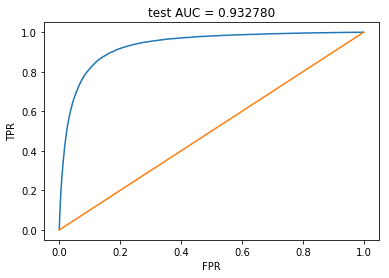

In [41]:
with open(predictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);


In [42]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.5 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.9477078745968989
precision 0.6499476439790576
recall 0.3112994633632579
f1 0.4209705313845841


array([[303249,   3343],
       [ 13732,   6207]], dtype=int64)